In [52]:
import pandas as pd
import json
from pandas.io.json import json_normalize

with open('/opt/ml/detection/dataset/train.json') as json_data:
    data = json.load(json_data)

df_imgs = pd.DataFrame(data['images'])
df_cats = pd.DataFrame(data['categories'])
df_annos = pd.DataFrame(data['annotations'])
category = ['General Trash','Paper','Paper pack','Metal','Glass','Plastic','Styrofoam','Plastic bag','Battery','Clothing']


In [53]:
df_img = pd.DataFrame(df_imgs, columns = ['file_name','id'])
df_img.head()

,file_name,id
0,train/0000.jpg,0
1,train/0001.jpg,1
2,train/0002.jpg,2
3,train/0003.jpg,3
4,train/0004.jpg,4


In [54]:
df_anno = df_annos.drop(["area", "iscrowd","id"],axis=1)
df_anno.head()

,image_id,category_id,bbox
0,0,0,"[197.6, 193.7, 547.8, 469.7]"
1,1,3,"[0.0, 407.4, 57.6, 180.6]"
2,1,7,"[0.0, 455.6, 144.6, 181.6]"
3,1,4,"[722.3, 313.4, 274.3, 251.9]"
4,1,5,"[353.2, 671.0, 233.7, 103.4]"


In [55]:
# category별 bbox의 개수 분포를 구하고
# 각 image별 max의 index를 category로 지정했을 때 분포를 비교해보자
df_anno.groupby("category_id").head()
group = df_anno['category_id'].value_counts().sort_index()


In [56]:
group = group.set_axis(category)

In [57]:
group.head(10)

General Trash    3966
Paper            6352
Paper pack        897
Metal             936
Glass             982
Plastic          2943
Styrofoam        1263
Plastic bag      5178
Battery           159
Clothing          468
Name: category_id, dtype: int64

In [58]:
ones = pd.Series(1, index=df_anno.index,name="flag")
df_anno = df_anno.join(ones)
df_anno.head(5)

,image_id,category_id,bbox,flag
0,0,0,"[197.6, 193.7, 547.8, 469.7]",1
1,1,3,"[0.0, 407.4, 57.6, 180.6]",1
2,1,7,"[0.0, 455.6, 144.6, 181.6]",1
3,1,4,"[722.3, 313.4, 274.3, 251.9]",1
4,1,5,"[353.2, 671.0, 233.7, 103.4]",1


In [59]:
anno = df_anno.groupby(["image_id","category_id"])["flag"].sum()
anno.head(5)

image_id  category_id
0         0              1
1         0              2
          3              1
          4              1
          5              2
Name: flag, dtype: int64

In [60]:
max_cat = anno.unstack()

In [61]:
max_cat = max_cat.idxmax(axis=1)

In [62]:
max_group = max_cat.value_counts().sort_index()
max_group = max_group.set_axis(category)

In [63]:
max_group.head(5)

General Trash    1322
Paper            1022
Paper pack        268
Metal             326
Glass             207
dtype: int64

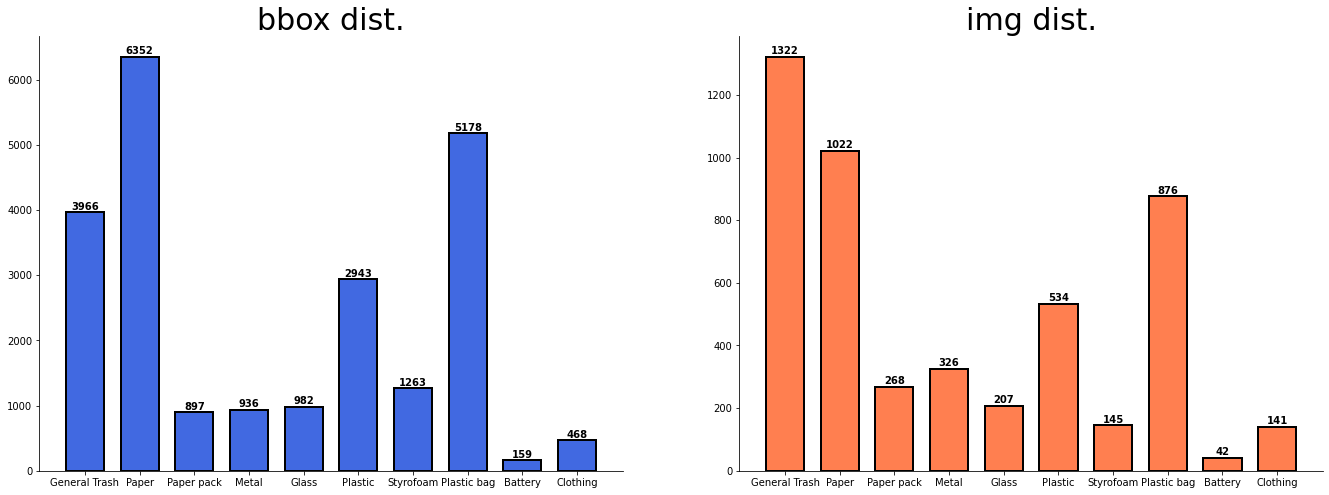

In [64]:
import matplotlib.pyplot as plt
# bbox의 분포와 max로 image를 classify 했을 때의 분포 비교
fig, axes = plt.subplots(1, 2, figsize=(23, 8))
axes[0].bar(group.index, group,
           width=0.7,
           edgecolor='black',
           linewidth=2,
           color='royalblue',
           zorder=10,
           )
for idx, value in zip(group.index, group):
    axes[0].text(idx, value+40, s=value,
                 ha='center', 
                 fontweight='bold'
    )
axes[0].set_title('bbox dist.',fontsize=30)
axes[1].bar(max_group.index, max_group,
           width=0.7,
           edgecolor='black',
           linewidth=2,
           color='coral',
           zorder=10,
           )
for idx, value in zip(max_group.index, max_group):
    axes[1].text(idx, value+10, s=value,
                 ha='center', 
                 fontweight='bold'
                )
axes[1].set_title('img dist.',fontsize=30)
for ax in axes:
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)

plt.show()

In [65]:
max_cat.name="category"
max_cat.head(5)

image_id
0    0
1    0
2    3
3    2
4    1
Name: category, dtype: int64

In [66]:
img = df_img.join(max_cat)[["file_name","category"]]
img.head(5)

,file_name,category
0,train/0000.jpg,0
1,train/0001.jpg,0
2,train/0002.jpg,3
3,train/0003.jpg,2
4,train/0004.jpg,1


In [67]:
import random
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

In [68]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [69]:
train_x = img
train_y = train_x.category.values
groups = np.array(train_x.file_name.values) 

def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [70]:
distrs = [get_distribution(train_y)]
index = ['training set']
train =[]
test =[]

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_x, train_y, groups, k=11)):
    dev_y, val_y = train_y[dev_ind], train_y[val_ind]
    dev_groups, val_groups = groups[dev_ind], groups[val_ind]
    train.append(dev_groups)
    test.append(val_groups)
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_y) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4,Label 5,Label 6,Label 7,Label 8,Label 9
training set,27.07%,20.93%,5.49%,6.68%,4.24%,10.94%,2.97%,17.94%,0.86%,2.89%
development set - fold 0,27.08%,20.95%,5.48%,6.67%,4.24%,10.94%,2.95%,17.95%,0.86%,2.89%
validation set - fold 0,27.01%,20.76%,5.58%,6.70%,4.24%,10.94%,3.12%,17.86%,0.89%,2.90%
development set - fold 1,27.08%,20.95%,5.48%,6.67%,4.24%,10.94%,2.95%,17.95%,0.86%,2.89%
validation set - fold 1,27.01%,20.76%,5.58%,6.70%,4.24%,10.94%,3.12%,17.86%,0.89%,2.90%
development set - fold 2,27.09%,20.94%,5.48%,6.67%,4.24%,10.93%,2.97%,17.94%,0.86%,2.88%
validation set - fold 2,26.91%,20.85%,5.61%,6.73%,4.26%,10.99%,2.91%,17.94%,0.90%,2.91%
development set - fold 3,27.09%,20.94%,5.48%,6.67%,4.24%,10.93%,2.97%,17.94%,0.86%,2.88%
validation set - fold 3,26.91%,20.85%,5.61%,6.73%,4.26%,10.99%,2.91%,17.94%,0.90%,2.91%
development set - fold 4,27.08%,20.93%,5.50%,6.67%,4.24%,10.93%,2.97%,17.94%,0.86%,2.88%


In [71]:
df_train = pd.DataFrame(train[1]).rename(columns = {0:'file_name'}, inplace=False)
df_train = df_train.join(pd.DataFrame(data["images"]).drop(["file_name","id"], axis=1))
df_id = df_train["file_name"].map(lambda x: int(x[6:10]))
df_id.name="id"
df_train = df_train.join(df_id).drop(["flickr_url","coco_url"],axis=1)
df_train.head(10)

,file_name,width,height,license,date_captured,id
0,train/0001.jpg,1024,1024,0,2020-12-26 14:44:23,1
1,train/0002.jpg,1024,1024,0,2021-01-10 16:30:39,2
2,train/0003.jpg,1024,1024,0,2020-12-27 17:55:52,3
3,train/0005.jpg,1024,1024,0,2021-03-31 12:10:36,5
4,train/0006.jpg,1024,1024,0,2021-01-01 18:52:38,6
5,train/0007.jpg,1024,1024,0,2021-01-02 16:48:22,7
6,train/0008.jpg,1024,1024,0,2020-12-27 17:09:20,8
7,train/0009.jpg,1024,1024,0,2021-03-27 13:33:26,9
8,train/0010.jpg,1024,1024,0,2020-12-27 17:12:18,10
9,train/0011.jpg,1024,1024,0,2020-12-26 14:32:48,11


In [72]:
train_anno = df_annos.loc[df_annos['image_id'].isin(df_train["id"])]
train_anno.head(10)

,image_id,category_id,area,bbox,iscrowd,id
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4
5,1,5,188324.40,"[3.7, 448.5, 778.2, 242.0]",0,5
6,1,0,38908.72,"[425.3, 681.9, 216.4, 179.8]",0,6
7,1,7,7391.52,"[92.4, 601.7, 139.2, 53.1]",0,7
8,1,0,6857.76,"[622.4, 686.5, 72.8, 94.2]",0,8
9,2,3,324010.80,"[267.9, 165.2, 631.6, 513.0]",0,9
10,3,2,59550.94,"[462.2, 369.4, 233.9, 254.6]",0,10


In [73]:
df_test = pd.DataFrame(test[1]).rename(columns = {0:'file_name'}, inplace=False)
df_test = df_test.join(pd.DataFrame(data["images"]).drop(["file_name","id"], axis=1))
df_id = df_test["file_name"].map(lambda x: int(x[6:10]))
df_id.name="id"
df_test = df_test.join(df_id).drop(["flickr_url","coco_url"],axis=1)
df_test.head(12)

,file_name,width,height,license,date_captured,id
0,train/0000.jpg,1024,1024,0,2020-12-26 14:44:23,0
1,train/0004.jpg,1024,1024,0,2021-01-10 16:30:39,4
2,train/0024.jpg,1024,1024,0,2020-12-27 17:55:52,24
3,train/0041.jpg,1024,1024,0,2021-03-31 12:10:36,41
4,train/0044.jpg,1024,1024,0,2021-01-01 18:52:38,44
5,train/0045.jpg,1024,1024,0,2021-01-02 16:48:22,45
6,train/0052.jpg,1024,1024,0,2020-12-27 17:09:20,52
7,train/0078.jpg,1024,1024,0,2021-03-27 13:33:26,78
8,train/0081.jpg,1024,1024,0,2020-12-27 17:12:18,81
9,train/0120.jpg,1024,1024,0,2020-12-26 14:32:48,120


In [74]:
test_anno = df_annos.loc[df_annos['image_id'].isin(df_test["id"])]
test_anno.head(14)

,image_id,category_id,area,bbox,iscrowd,id
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0
12,4,1,14768.88,"[567.5, 462.2, 165.2, 89.4]",0,12
13,4,1,32987.78,"[859.4, 411.7, 164.2, 200.9]",0,13
14,4,1,32747.00,"[362.0, 349.7, 130.0, 251.9]",0,14
15,4,1,54208.40,"[392.5, 348.4, 212.0, 255.7]",0,15
16,4,1,57900.45,"[482.2, 491.4, 277.7, 208.5]",0,16
17,4,0,4523.64,"[868.2, 521.7, 101.2, 44.7]",0,17
117,24,0,176296.50,"[381.3, 311.6, 405.0, 435.3]",0,117
175,41,0,107125.10,"[464.3, 0.0, 559.4, 191.5]",0,175
176,41,7,14079.16,"[489.3, 0.0, 104.6, 134.6]",0,176


In [75]:
data_test_anno = []
data_test_image = []
data_test_cat = data['categories']
for i in range(len(df_test)):
    set_data={}
    temp = df_test.iloc[i]
    for key in temp.keys():
        set_data[key]=temp[key]
    data_test_image.append(set_data)
for i in range(len(test_anno)):
    set_data={}
    temp = test_anno.iloc[i]
    for key in temp.keys():
        set_data[key]=temp[key]
    data_test_anno.append(set_data)

In [76]:
data_train_anno = []
data_train_image = []
data_train_cat = data['categories']
for i in range(len(df_train)):
    set_data={}
    temp = df_train.iloc[i]
    for key in temp.keys():
        set_data[key]=temp[key]
    data_train_image.append(set_data)
for i in range(len(train_anno)):
    set_data={}
    temp = train_anno.iloc[i]
    for key in temp.keys():
        set_data[key]=temp[key]
    data_train_anno.append(set_data)

In [77]:
import json
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)


data_test ={"images":data_test_image,"categories":data_test_cat,"annotations":data_test_anno}
data_train = {"images":data_train_image,"categories":data_train_cat,"annotations":data_train_anno}
jsonFilePath_train = r'/opt/ml/detection/dataset/train_kfold1.json'
jsonFilePath_test = r'/opt/ml/detection/dataset/test_kfold1.json'
with open(jsonFilePath_train, 'w',encoding='utf-8') as jsonf:
    jsonf.write(json.dumps(data_train, cls = NpEncoder, indent=4))
with open(jsonFilePath_test, 'w',encoding='utf-8') as jsonf:
    jsonf.write(json.dumps(data_test, cls = NpEncoder, indent=4))

In [78]:
print(len(df_test))
print(len(df_train))

448
4435
